# import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import tensorflow as tf
import pathlib
import PIL
import time
import zipfile
import random
from tensorflow import keras as ks
from tensorflow.keras.layers import *
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

**Read data**

In [2]:
train=pd.read_csv("../input/sign-recognition/Train.csv")
test=pd.read_csv("../input/sign-recognition/Test.csv")

# General insights 

In [3]:
train.shape, test.shape

((5000, 4098), (5000, 4097))

In [4]:
train.isna().sum()

ID        0
c00000    0
c00001    0
c00002    0
c00003    0
         ..
c04092    0
c04093    0
c04094    0
c04095    0
Target    0
Length: 4098, dtype: int64

# Drop ID column and define train_y , train_x , test_x

In [5]:
train_y=train['Target'].astype('float32')
train_x=train.drop(['Target','ID'],axis=1).astype('int32')
test_x=test.drop(['ID'],axis=1).astype('int32')
train_x.shape,train_y.shape,test_x.shape

((5000, 4096), (5000,), (5000, 4096))

# One Hot Encoding for train_y

In [6]:
train_y=tf.keras.utils.to_categorical(train_y,10)
train_y.shape

(5000, 10)

In [7]:
train_y

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Reshape the size of  images and normalize them  

In [8]:
train_x=train_x.values.reshape(-1,64,64,1)
train_x=train_x/255.0
test_x=test_x.values.reshape(-1,64,64,1)
test_x/255.0
test_x.shape,train_x.shape

((5000, 64, 64, 1), (5000, 64, 64, 1))

# plotting some exemple

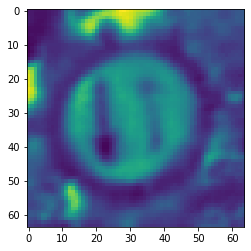

In [9]:
g =plt.imshow(train_x[150][:,:,0]) 

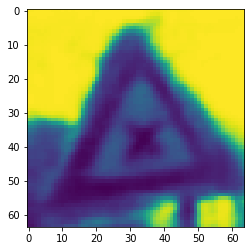

In [10]:
b = plt.imshow(test_x[500][:,:])

In [11]:
x_train , x_test, y_train , y_test=train_test_split(train_x, train_y , test_size=0.15)

In [12]:
x_train.shape , y_train.shape,x_test.shape , y_test.shape

((4250, 64, 64, 1), (4250, 10), (750, 64, 64, 1), (750, 10))

# Generating new images 

In [13]:
datagenerator = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


In [14]:
train_generator = datagenerator.flow(x_train,y_train,)

In [15]:
validation_generator = datagenerator.flow(x_test, y_test)

# Visualizing some exemple of generating images

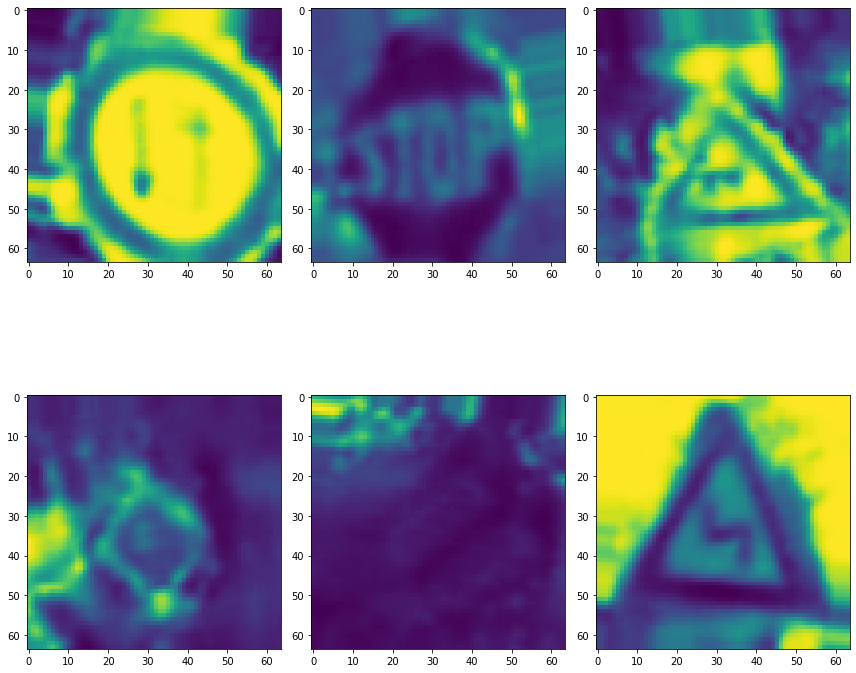

In [16]:
plt.figure(figsize=(12, 12))
for i in range(0, 6):
    plt.subplot(2, 3, i+1)
    for X_batch, Y_batch in validation_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

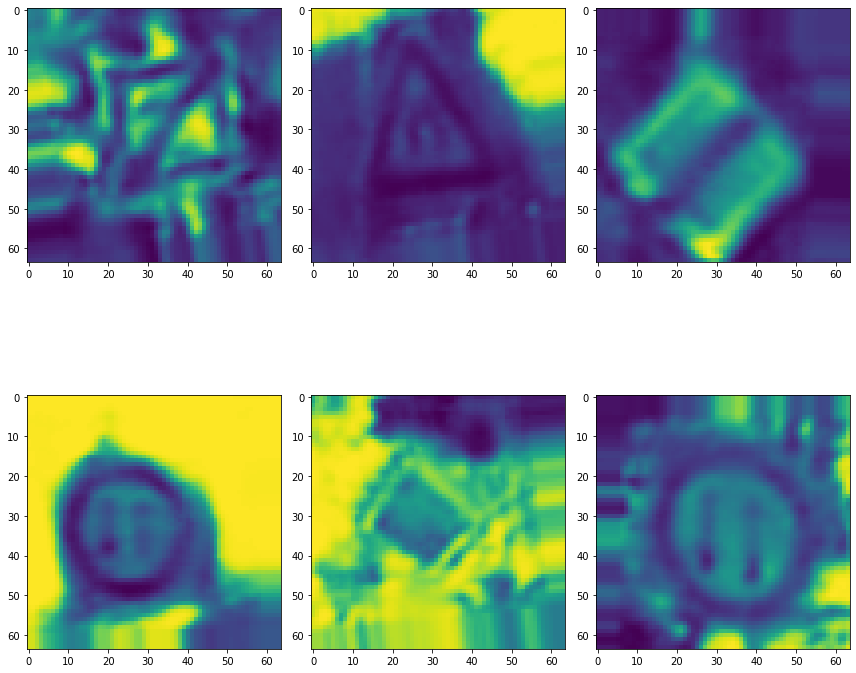

In [17]:
plt.figure(figsize=(12, 12))
for i in range(0, 6):
    plt.subplot(2, 3, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Modeling

In [18]:
        model = ks.models.Sequential()

        model.add(ks.layers.Dense(4, input_shape=(64, 64, 1)))
        model.add(ks.layers.Dense(8, input_shape=(64, 64, 1)))
        model.add(ks.layers.Dense(8, input_shape=(64, 64, 1)))

        model.add(ks.layers.Conv2D(64, (3, 3), activation='relu'))
        model.add(ks.layers.MaxPooling2D(2, 2))
    
        

        model.add(ks.layers.Conv2D(128, (3, 3), activation='relu'))
        model.add(ks.layers.MaxPooling2D(2, 2))


        model.add(ks.layers.Conv2D(256, (3, 3), activation='relu'))
        model.add(ks.layers.MaxPooling2D(2, 2))

        

        model.add(ks.layers.Conv2D(512, (3, 3), activation='relu'))
        model.add(ks.layers.MaxPooling2D(2, 2))
        model.add(ks.layers.Dropout(0.2))


        
        model.add(ks.layers.Flatten())
        
        model.add(ks.layers.Dense(1024, activation='relu'))

        model.add(ks.layers.Dense(10, activation='softmax'))

        model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

2022-06-27 07:54:12.282571: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


# Model summary

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64, 64, 4)         8         
_________________________________________________________________
dense_1 (Dense)              (None, 64, 64, 8)         40        
_________________________________________________________________
dense_2 (Dense)              (None, 64, 64, 8)         72        
_________________________________________________________________
conv2d (Conv2D)              (None, 62, 62, 64)        4672      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 128)       0

In [20]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

In [21]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>0.84) and (logs.get('val_acc')>0.82):
            print('\n reached 84% accuarcy so stopping training')
            self.model.stop_training = True
callbacks = myCallback()

In [22]:
batch_size=5
FAST_RUN = False
epochs=20 if FAST_RUN else 100
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(), 
        callbacks
    ]
)

2022-06-27 07:54:12.797645: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
133/133 [==============================] - 46s 337ms/step - loss: 1.9097 - acc: 0.2584 - val_loss: 1.2434 - val_acc: 0.4813
Epoch 2/100
133/133 [==============================] - 44s 328ms/step - loss: 1.0214 - acc: 0.5859 - val_loss: 0.8808 - val_acc: 0.6480
Epoch 3/100
133/133 [==============================] - 44s 332ms/step - loss: 0.7511 - acc: 0.6953 - val_loss: 0.7359 - val_acc: 0.6920
Epoch 4/100
133/133 [==============================] - 44s 327ms/step - loss: 0.6398 - acc: 0.7522 - val_loss: 0.6200 - val_acc: 0.7467
Epoch 5/100
133/133 [==============================] - 45s 335ms/step - loss: 0.5810 - acc: 0.7718 - val_loss: 0.5794 - val_acc: 0.7813
Epoch 6/100
133/133 [==============================] - 44s 328ms/step - loss: 0.5572 - acc: 0.7854 - val_loss: 0.5415 - val_acc: 0.8013
Epoch 7/100
133/133 [==============================] - 43s 324ms/step - loss: 0.5381 - acc: 0.7920 - val_loss: 0.5347 - val_acc: 0.8013
Epoch 8/100
133/133 [===========================

# making prediction

In [23]:
result=model.predict(test_x)
result=np.argmax(result,axis=1)
result=pd.Series(result,name="Target")

In [24]:
result

0       0
1       8
2       2
3       7
4       6
       ..
4995    6
4996    5
4997    0
4998    1
4999    9
Name: Target, Length: 5000, dtype: int64